# Data cleaning, so we can build a classifiier

### **Note:** Remember to check which environment this notebook is using!

## Steps in this notebook
1. Get the packages we need (install -> import)
2. `emnist` pulls a clean dataset of handwritten characters
    1. Clean dataframes are `raw_train` and `raw_test`
    2. Each has only two columns
        1. 'image' - 28x28 pixel array images of handwritten characters
        2. 'label' - different number for class of digit: 0 -> 0, 10 -> A, 61 -> z
3. Demonstrate basic plotting of the images
4. Intentionally dirty this clean dataset
    1. Dirty dataframes are `dirty_train` and `dirty_test`
    2. Look through how the dirtying process works for ideas on how to clean up
5. Space for whatever you're going to do next
    1. Get cleaning with pandas
    2. Build classifiers with the data you've cleaned
    3. Skip data cleaning and build classifier with the raw data

# Install packages

Uncomment the followinig lines the first time running this notebook in this environment
`%conda install pandas numpy emnist matplotlib`
`%pip install emnist`

In [1]:
# Import packages
# Install packages
#%pip install emnist
#%pip install pandas numpy emnist matplotlib
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emnist
from hashlib import sha1

In [2]:
# The size of each image is 28x28 pixels
size = 28 

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
raw_train = pd.DataFrame()

# Add a column showing the label
raw_train['label'] = label

# Add a column with the image data as a 28x28 array
raw_train['image'] = list(image)


# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
raw_test = pd.DataFrame()
raw_test['label'] = label
raw_test['image'] = list(image)

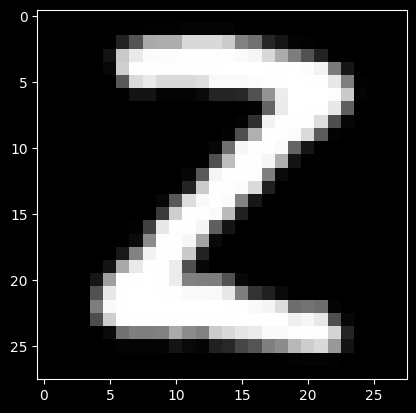

In [3]:
# We can plot individual images using matplotlib
plt.imshow(raw_train['image'][0], cmap='gray')
plt.show() # Show the plot (optional with a single image)

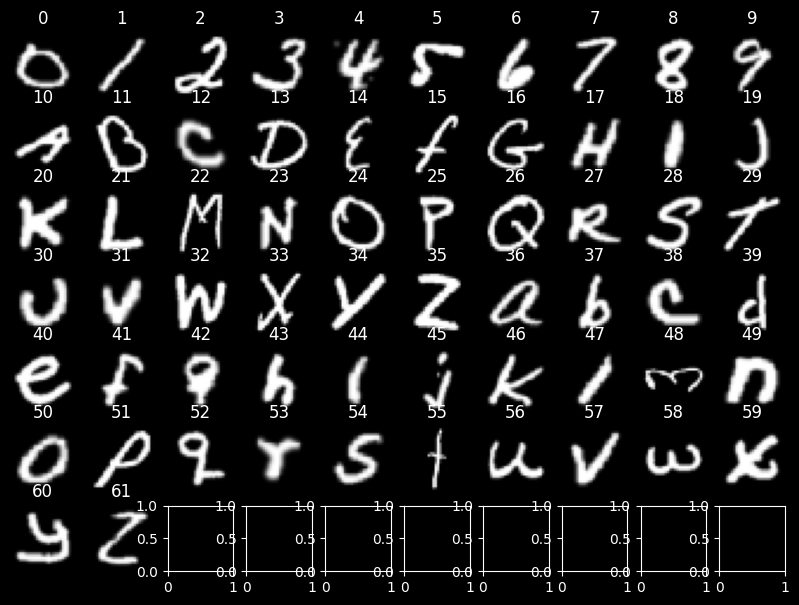

In [4]:
# Get the first row for each label
firsts = raw_train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

# Getting dirty

Now that we've got the data in good shape, let's rough it up a little.

- [x] Add `predicit` col with confidence probabilities from a previous model
- [x] Numerical:
    - [x] outlier
    - [x] out-of-bounds
- [x] Labels: missing(Null, None, "", " "), name that number, double-struck
- [x] Image: zeroed, null? dimensions?
- [x] Image: add noise
- [x] Image: flip horizonally
- [x] Duplicated rows

In [5]:
# Now let's mess up the data a bit

# Percent of the time something dirty happens (0.1%) for each method
pct = 0.001 

# Copy the splits into new dataframes to mess up
dirty_train = raw_train.copy()
dirty_test  = raw_test.copy()

# Add a column for a hash of the images (should make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())

# For each row, 0.1% of the time, duplicate the row
dirty_train = pd.concat([dirty_train, dirty_train.sample(frac=pct)])
dirty_test  = pd.concat([dirty_test,   dirty_test.sample(frac=pct)])

# For each row, 0.1% of the time, zero out the image array
dirty_train['image'] = dirty_train['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)
dirty_test['image']  =  dirty_test['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)

# Add a column for classification scores from a previous model
dirty_train['predict'] = np.random.normal(0.75, 0.1, dirty_train.shape[0])
dirty_test['predict']  = np.random.normal(0.75, 0.1, dirty_test.shape[0])

# For each row, 0.1% of the time, replace the predict column with a normal distribution centered on 0.25
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)

# For each row, 0.1% of the time, add/subtract 1 to the predict column
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)

# For each row, 0.1% of the time, choose a column at random and set it to NaN
dirty_train = dirty_train.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)
dirty_test  =  dirty_test.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)

# Mislabel 0.1% of the data with strings that look like labels or missing values (e.g., names like "one", numbers greater than 62, " ")
# Create a list of bad labels
bad_labels = ['number', 'letter', 'maybe three?', 'think this is a seven', ' ', '', 'NaaN', 'Null'] + list(range(63, 100))
# For 0.1% of the rows, randomly choose a bad label
dirty_train['label'] = dirty_train['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)
dirty_test['label']  =  dirty_test['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)




# TEMPLATE: For each row, PCT% of the time, randomly apply METHOD() to the COLUMN
# df['COLUMN'] = dirty_train['column'].apply(lambda x: METHOD(x) if np.random.rand() < PCT else x)

# Not applying these for now, but they're here if you want to try them

# For each row, randomly decide whether to apply a random noise
# dirty_train['image'] = dirty_train['image'].apply(lambda x: x + np.random.rand(size, size) if np.random.rand() < 0.1 else x)

# For each row, randomly decide whether to flip the image horizontally
#dirty_train['image'] = dirty_train['image'].apply(lambda x: np.flip(x, axis=1) if np.random.rand() < 0.1 else x)


In [6]:
dirty_test

,label,image,image_hash,predict
0,18.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3d4e830e01cd8f7ef77adfb3cdfecc0106f44f9a,0.785244
1,36.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",e1038df7a2b42e643c559a183fadc1a237126159,0.720523
2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8288d8ed0c2a0ab66d8cf0d84c6bfcdb82e2153b,0.596674
3,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a89fcbe79c54a670089afa74eeffc01b196849e8,0.836109
4,33.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",336637f2e63d571bea6336e45c83ddd704c71735,0.974198
...,...,...,...,...
63816,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7a2819ce6c0397b849a220ea74b7f4be7cea94ab,0.812404
34124,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a99f159cc1fc7075a1a6bbd2477bf6495a27c1df,0.642875
34545,28.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",415abe9d7858a0e600393c0d69bbd12bab37e2ed,0.639334
1453,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1e155767fbdc67ba806baba2d2b4aa236bcd6125,0.690124


In [7]:
# Katherine already generated the dirty data, so I'm just going to run from her pickle files, ignore this cell

#dirty_test.to_pickle('dirty_test_20240123.pkl')
#dirty_train.to_pickle('dirty_train_20240123.pkl')

In [8]:
dirty_test = pd.read_pickle("./dirty_test_20240123.pkl")  
dirty_train = pd.read_pickle("./dirty_train_20240123.pkl")  

In [9]:
dirty_test

,label,image,image_hash,predict
0,18.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3d4e830e01cd8f7ef77adfb3cdfecc0106f44f9a,0.818040
1,36.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",e1038df7a2b42e643c559a183fadc1a237126159,0.767228
2,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8288d8ed0c2a0ab66d8cf0d84c6bfcdb82e2153b,0.717551
3,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a89fcbe79c54a670089afa74eeffc01b196849e8,0.444503
4,33.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",336637f2e63d571bea6336e45c83ddd704c71735,0.707221
...,...,...,...,...
98722,7.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9c2efc32e86c6a656b733d01f34ef5d5a2832603,0.838210
67860,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6e90c681976aacf3546bf573ed4ebc9642676a53,0.802398
93172,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",66d173e9024d2ee7d5a15abbc0d81a7446a12f1d,0.662314
96548,51.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",51d1e17a7203ad5f5350ad72620ddf1d29cbdf84,0.635502


# Exercise

The changes above were applied randomly, so we'll need to find them and make a plan to fix them.

- [ ] Create a column to identify whether each row came from *train* or *test*
- [ ] (optional) Merge the data into a single
- [ ] Explore the data to understand what's in it
- [ ] List potential data issues to fix
    - Duplicate rows
    - Missing values
    - Outliers and out-of-bounds issues
    - Label issues
    - Image issues
    - Zeroed values
- [ ] Create a friendlier column for image labels
- [ ] Recategorizing the labels into 'numbers' and 'letters'
- [ ] Bin the prediction scores of the previous model

In [10]:
# Let's start cleaning!

# Labels! They're hard to understand as numbers, so let's map them to characters
# We can do this by manually creating a dictionary:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Or generate the list of labels using the following code:
# create the characters list, which is the digits, then uppercase, then lowercase
chars = string.digits + string.ascii_uppercase + string.ascii_lowercase
# create the dictionary mapping the numbers to the characters
num_to_char = {i: chars[i] for i in range(len(chars))}

# Add a column showing which split (train vs test) each row came from
raw_train['split'] = 'train'
raw_test['split']  = 'test'
dirty_train['split'] = 'train'
dirty_test['split'] = 'test'

# Add a column for a hash of the images (might make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())

In [12]:
merged = pd.concat([dirty_test, dirty_train], axis=0)

In [38]:
# get an overview of the data

def broad_picture(df):
    """Get a broad overview of what this dataframe contains.
    :params: pandas dataframe"""

    # get the info
    print("Give me the info:")
    print(df.info)

    # what is the shape of the data.
    print("\nChecking the dimensions:")
    print(df.shape)

    # Check the first few entries of the column
    print("\nLast few entries in the column:")
    print(df.tail)

broad_picture(merged)


# Iterating over each column and printing its data type
for column in merged.columns:
    print(f"Column: {column}, Data Type: {merged[column].dtype}")


Give me the info:
<bound method DataFrame.info of        label                                              image  \
0       18.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1       36.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2        0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3        3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4       33.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...      ...                                                ...   
197050   3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
512312   3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
347227   3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
672276  21.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
86154   22.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      image_hash   predict  split  
0       3d4e830e01cd8f7ef77adfb3cdfecc0106f44f9a  0.818040   test  
1       e

In [31]:
# Examine the data using a customized function. 
def examine_the_data(df):
    """
    :Examines the MNIST data for dirt in the dataframe: 
    Check rows for missing values, check for duplicated rows, examine the label and image column for dirty entries -
    labels that are not numeric and between 0 and 61, check for zeroed out arrays, .

    :param df: pandas DataFrame
    """
  
    
    # Check for missing values
    if df.isnull().values.any():
        missing_rows = df[df.isnull().any(axis=1)]
        print("Rows with missing values:")
        print(missing_rows)
    else:
        print("No missing values found in the DataFrame.")

    # Check for non-numeric values in 'label' column
    if not pd.api.types.is_numeric_dtype(df['label']):
        non_numeric_rows = df[pd.to_numeric(df['label'], errors='coerce').isna()]
        print("Rows with non-numeric values in 'label' column:")
        print(non_numeric_rows)
    
    # Check for numeric values greater than 62 in 'label' column
    if df['label'].dtype.kind in 'biufc':  # Checks if the column data type is numeric
        out_of_bounds_rows = df[df['label'] > 62]
        print("Rows with 'label' values greater than 62:")
        print(out_of_bounds_rows)

    # Check for zeroed arrays in 'image' column
    zeroed_array_rows = df[df['image'].apply(lambda x: np.all(x == 0))]
    if not zeroed_array_rows.empty:
        print("Rows with completely zeroed arrays in 'image' column:")
        print(zeroed_array_rows)



In [45]:
# Count duplicates across the entire DataFrame using the image_hash
total_duplicates = merged['image_hash'].duplicated().sum()
print(f"Total duplicated rows in the DataFrame: {total_duplicates}")


# run the examine_the_data function
examine_the_data(merged)

Total duplicated rows in the DataFrame: 2024
Rows with missing values:
       label                                              image  \
175     18.0                                                NaN   
1000     NaN                                                NaN   
1561     NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6188     NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6224     NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...      ...                                                ...   
692271   NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
693038   NaN                                                NaN   
693528   4.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
696211   NaN                                                NaN   
697002   NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      image_hash   predict  split  
175     c1cee032e48ec3238bd16efe4a9e72da72e35e08       N

In [60]:
# clean up on aisle data


# Convert 'label' column to numeric, coercing errors to NaN
merged['label'] = pd.to_numeric(merged['label'], errors='coerce')
# Filter the DataFrame to keep only rows where 'label' values are between 0 and 61
merged_filt = merged[(merged['label'] >= 0) & (merged['label'] <= 61)]
# Optional: Remove rows with NaN in 'label' column if any non-numeric values were present
merged_filt = merged_filt.dropna(subset=['label'])
# switch to integer type
merged_filt['label'] = merged_filt['label'].astype(int)

# Now replace the label with the clean labels
merged_filt['labels_clean'] = merged_filt['label'].map(num_to_char)



# Now create and indicator column for whether the label is a number or a letter
def categorize_label(label):
    if str(label).isdigit() and 0 <= int(label) <= 9:
        return "number"
    else:
        return "letter"

# Apply the function to the 'labels' column
merged_filt['category'] = merged_filt['label'].apply(categorize_label)

# bin the prediction scores
# Define score bins and labels
bins = [0, .50, .80, 1.0]
labels = ['Poor', 'Moderate', 'Excellent']

# Bin the 'score' column
merged_filt['prediction_quality'] = pd.cut(merged_filt['predict'], bins=bins, labels=labels, include_lowest=True)

print(merged_filt)

        label                                              image  \
0          18  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1          36  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2           0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3           3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4          33  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...       ...                                                ...   
197050      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
512312      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
347227      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
672276     21  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
86154      22  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      image_hash   predict  split  \
0       3d4e830e01cd8f7ef77adfb3cdfecc0106f44f9a  0.818040   test   
1       e1038df7a2b42e643c559a183fadc1a237126